
Epoch 1/10


Training Loss: 1.2876, Accuracy: 0.5048


Validation Loss: 0.9269, Accuracy: 0.6426

Epoch 2/10


Training Loss: 0.8353, Accuracy: 0.6836


Validation Loss: 0.6831, Accuracy: 0.7571

Epoch 3/10


Training Loss: 0.6136, Accuracy: 0.7726


Validation Loss: 0.5528, Accuracy: 0.7933

Epoch 4/10


Training Loss: 0.4509, Accuracy: 0.8391


Validation Loss: 0.4391, Accuracy: 0.8432

Epoch 5/10


Training Loss: 0.3456, Accuracy: 0.8792


Validation Loss: 0.3848, Accuracy: 0.8725

Epoch 6/10


Training Loss: 0.2736, Accuracy: 0.9003


Validation Loss: 0.3375, Accuracy: 0.8785

Epoch 7/10


Training Loss: 0.2036, Accuracy: 0.9250


Validation Loss: 0.3248, Accuracy: 0.8901

Epoch 8/10


Training Loss: 0.1362, Accuracy: 0.9519


Validation Loss: 0.3090, Accuracy: 0.9047

Epoch 9/10


Training Loss: 0.0973, Accuracy: 0.9672


Validation Loss: 0.3874, Accuracy: 0.8780

Epoch 10/10


Training Loss: 0.0648, Accuracy: 0.9819


C:\Users\Jaber\AppData\Local\Temp\ipykernel_4484\921443991.py:425: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Validation Loss: 0.4281, Accuracy: 0.8936


Test Loss: 0.3663, Accuracy: 0.8891
Precision: 0.8930, Recall: 0.8891, F1 Score: 0.8905


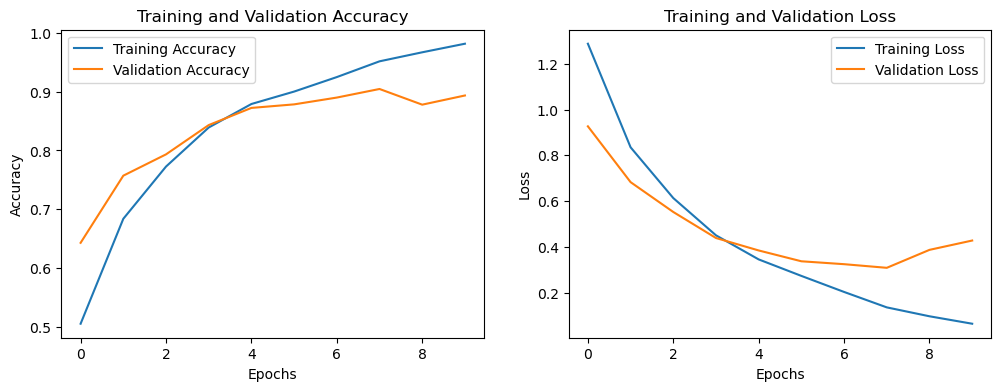

In [1]:
# PyTorch Implementation of Swin Transformer, ConvNeXt, and AGFF with Revisions

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from datetime import datetime
from tqdm import tqdm  # For progress bars

# Parameters
num_classes = 6
image_size = (224, 224)
dropout_rate = 0.1
batch_size = 8
epochs = 10
learning_rate = 1e-4
window_size = 7  # Swin Transformer window size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Attention-Guided Feature Fusion (AGFF) Layer with Feature Calibration
class AttentionGuidedFeatureFusion(nn.Module):
    def __init__(self, conv_channels=768, swin_channels=768):
        super(AttentionGuidedFeatureFusion, self).__init__()
        num_channels = (conv_channels // 2) + (swin_channels // 2)  # 384 + 384 = 768

        # Spatial Attention Mechanism
        self.conv_spatial = nn.Conv2d(num_channels, 1, kernel_size=1)
        self.sigmoid_spatial = nn.Sigmoid()

        # Channel Attention Mechanism
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dense1 = nn.Linear(num_channels, num_channels // 8)  # 768 // 8 = 96
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(num_channels // 8, num_channels)
        self.sigmoid_channel = nn.Sigmoid()

        # Feature calibration layers
        self.norm1 = nn.LayerNorm(conv_channels)
        self.norm2 = nn.LayerNorm(swin_channels)
        self.proj_conv = nn.Linear(conv_channels, conv_channels // 2)
        self.proj_swin = nn.Linear(swin_channels, swin_channels // 2)

        # Re-weighting parameters
        self.weight_conv = nn.Parameter(torch.ones(1))
        self.weight_swin = nn.Parameter(torch.ones(1))

    def forward(self, conv_features, swin_features):
        # Feature Calibration
        B, C, H, W = conv_features.shape
        conv_features = conv_features.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        swin_features = swin_features.permute(0, 2, 3, 1).contiguous()

        conv_features = self.norm1(conv_features)
        swin_features = self.norm2(swin_features)

        conv_features = self.proj_conv(conv_features)  # [B, H, W, 384]
        swin_features = self.proj_swin(swin_features)  # [B, H, W, 384]

        conv_features = conv_features * self.weight_conv
        swin_features = swin_features * self.weight_swin

        # Concatenate calibrated features
        combined_features = torch.cat([conv_features, swin_features], dim=-1)  # [B, H, W, 768]
        combined_features = combined_features.permute(0, 3, 1, 2).contiguous()  # [B, 768, H, W]

        # Spatial Attention
        spatial_attention = self.conv_spatial(combined_features)
        spatial_attention = self.sigmoid_spatial(spatial_attention)
        spatial_attention = spatial_attention * combined_features

        # Channel Attention
        channel_attention = self.global_avg_pool(combined_features).view(B, -1)
        channel_attention = self.dense1(channel_attention)
        channel_attention = self.relu(channel_attention)
        channel_attention = self.dense2(channel_attention)
        channel_attention = self.sigmoid_channel(channel_attention).view(B, -1, 1, 1)
        channel_attention = combined_features * channel_attention

        # Fuse
        fused_output = spatial_attention + channel_attention
        return fused_output

# Swin Transformer Components
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size=7, mlp_ratio=4., dropout=0.):
        super(SwinTransformerBlock, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size

        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.drop1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x: [B, N, C]
        B, N, C = x.shape
        shortcut = x
        x = self.norm1(x)
        x = x.transpose(0, 1)  # [N, B, C] for MultiheadAttention
        attn_output, _ = self.attn(x, x, x)
        x = attn_output.transpose(0, 1)
        x = self.drop1(x)
        x = shortcut + x

        # MLP
        shortcut2 = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = shortcut2 + x

        return x

class SwinTransformerStage(nn.Module):
    def __init__(self, dim, num_heads, window_size=7, num_blocks=2, mlp_ratio=4., dropout=0., downsample=True):
        super(SwinTransformerStage, self).__init__()
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim, num_heads, window_size, mlp_ratio, dropout)
            for _ in range(num_blocks)
        ])
        self.norm = nn.LayerNorm(dim)
        self.downsample = downsample
        if self.downsample:
            self.downsample_layer = nn.Conv2d(dim, dim * 2, kernel_size=2, stride=2)

    def forward(self, x, H, W):
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        x = x.view(-1, H, W, x.size(-1)).permute(0, 3, 1, 2).contiguous()
        if self.downsample:
            x = self.downsample_layer(x)
            H, W = H // 2, W // 2
            x = x.flatten(2).transpose(1, 2)
        else:
            x = x.flatten(2).transpose(1, 2)
        return x, H, W

class SwinTransformer(nn.Module):
    def __init__(self, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., dropout=0.):
        super(SwinTransformer, self).__init__()
        self.embed_dim = embed_dim
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=4, stride=4)
        self.stages = nn.ModuleList()
        dims = [embed_dim * (2 ** i) for i in range(len(depths))]
        for i in range(len(depths)):
            stage = SwinTransformerStage(
                dim=dims[i],
                num_heads=num_heads[i],
                window_size=window_size,
                num_blocks=depths[i],
                mlp_ratio=mlp_ratio,
                dropout=dropout,
                downsample=(i < len(depths) - 1)
            )
            self.stages.append(stage)

    def forward(self, x):
        x = self.patch_embed(x)  # [B, C, H, W]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        for stage in self.stages:
            x, H, W = stage(x, H, W)
        x = x.view(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        return x  # [B, C, H, W]

# ConvNeXt Components
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super(ConvNeXtBlock, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim)
        self.pwconv1 = nn.Linear(dim, dim * 4)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(dim * 4, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
        self.drop_path = nn.Dropout(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1).contiguous()  # NCHW -> NHWC
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = self.gamma * x
        x = x.permute(0, 3, 1, 2).contiguous()  # NHWC -> NCHW
        x = input + self.drop_path(x)
        return x

class ConvNeXtStage(nn.Module):
    def __init__(self, dim, depth, drop_path_rates, layer_scale_init_value=1e-6, downsample=True):
        super(ConvNeXtStage, self).__init__()
        self.blocks = nn.ModuleList([
            ConvNeXtBlock(dim, drop_path=drop_path_rates[i], layer_scale_init_value=layer_scale_init_value)
            for i in range(depth)
        ])
        self.downsample = downsample
        if self.downsample:
            self.downsample_layer = nn.Conv2d(dim, dim * 2, kernel_size=2, stride=2)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        if self.downsample:
            x = self.downsample_layer(x)
        return x

class ConvNeXt(nn.Module):
    def __init__(self, in_chans=3, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768],
                 drop_path_rate=0.2, layer_scale_init_value=1e-6):
        super(ConvNeXt, self).__init__()
        self.downsample_layers = nn.ModuleList()
        stem = nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4)
        self.downsample_layers.append(stem)
        self.stages = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(len(depths)):
            stage = ConvNeXtStage(
                dim=dims[i],
                depth=depths[i],
                drop_path_rates=dp_rates[cur:cur+depths[i]],
                layer_scale_init_value=layer_scale_init_value,
                downsample=(i < len(depths) - 1)
            )
            self.stages.append(stage)
            cur += depths[i]

    def forward(self, x):
        x = self.downsample_layers[0](x)
        for stage in self.stages:
            x = stage(x)
        return x  # [B, C, H, W]

# Feature Alignment Layer
class FeatureAlignmentLayer(nn.Module):
    def __init__(self):
        super(FeatureAlignmentLayer, self).__init__()

    def forward(self, conv_features, swin_features):
        conv_shape = conv_features.shape[-2:]
        swin_features = F.interpolate(swin_features, size=conv_shape, mode='bilinear', align_corners=False)
        return swin_features

# Create the combined model
class ConvNeXtSwinModel(nn.Module):
    def __init__(self, num_classes=6):
        super(ConvNeXtSwinModel, self).__init__()
        self.convnext = ConvNeXt()
        self.swin_transformer = SwinTransformer()
        self.feature_alignment = FeatureAlignmentLayer()
        self.agff = AttentionGuidedFeatureFusion()
        self.norm = nn.LayerNorm(768)
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(768, num_classes)
        )

    def forward(self, x):
        conv_features = self.convnext(x)  # [B, 768, H, W]
        swin_features = self.swin_transformer(x)  # [B, 768, H, W]
        swin_features = self.feature_alignment(conv_features, swin_features)
        fused_features = self.agff(conv_features, swin_features)
        B, C, H, W = fused_features.shape
        fused_features = fused_features.permute(0, 2, 3, 1).contiguous().view(-1, C)
        fused_features = self.norm(fused_features)
        fused_features = fused_features.view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        output = self.head(fused_features)
        return output

# Instantiate Model
model = ConvNeXtSwinModel(num_classes=num_classes).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Data Loading and Preprocessing
csv_path = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\FETAL_PLANES_DB_data.csv"
df = pd.read_csv(csv_path, delimiter=";")

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Add .png extension to each image name
df["Image_name"] = df["Image_name"].apply(lambda x: f"{x}.png")

# Split into train+val and test sets
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define Transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = sorted(df['Plane'].unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'Image_name']
        label_name = self.df.loc[idx, 'Plane']
        label = self.class_to_idx[label_name]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Image Directory
img_dir = r"C:\Users\Jaber\OneDrive - University of Florida\Educational\GitHub\Ultrasound_Fetal\Data\Images"

# Datasets
full_dataset = CustomImageDataset(train_val_df, img_dir, transform)
test_dataset = CustomImageDataset(test_df, img_dir, transform)

# Train-Validation Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Set num_workers=0
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)    # Set num_workers=0
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)  # Set num_workers=0

# Training Loop
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
patience_counter = 0
max_patience = 3  # Early stopping patience

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"\nEpoch {epoch + 1}/{epochs}")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter > max_patience:
            print("Early stopping triggered")
            break

# Load Best Model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on Test Data
model.eval()
test_running_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_preds = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Testing", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_loss = test_running_loss / len(test_loader.dataset)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

# Calculate Metrics
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Visualization of Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
